In [1]:
import GEMS
import pandas as pd
import numpy as np
import os
import cobra


import pickle
from etcpy import etc
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

In [2]:
path = '../'
params = pd.read_csv(os.path.join(path,'data/model_enzyme_params.csv'),index_col=0)
dfae_batch,dfan_batch = GEMS.load_exp_batch_data(os.path.join(path,'data/ExpGrowth.tsv'))
dfchemo = pd.read_csv(os.path.join(path,'data/Chemostat_exp_data.txt'),sep='\t',index_col=0)

In [3]:
def aerobic(params):
    # thermalParams: a dictionary with ids like uniprotid_Topt 
    df = etc.calculate_thermal_params(params)
    mae = pickle.load(open(os.path.join(path,'models/aerobic.pkl'),'rb'))
    
    try: rae = etc.simulate_growth(mae,dfae_batch.index+273.15,df=df,sigma=0.5)
    except: rae = np.zeros(dfae_batch.shape[0])
    
    rae = [0 if x is None else x for x in rae]
    rae = [0 if x<1e-3 else x for x in rae]
    print(rae)
    rexp = GEMS.aerobic_exp_data()['data']
    
    print('r2_batch:',r2_score(rexp,rae))
    print('MSE_ae',MSE(rexp,rae))
    return {'data':np.array(rae)}

In [4]:
params

,Topt,Topt_std,Length,Tm,Tm_std,T90,dCpt,dCpt_std
O13525,310.15,13,335,324.625351,5.91247,NaN,-6300,2000
P00044,314.15,13,109,321.817780,3.40000,324.65,-6300,2000
P00045,317.15,13,113,324.625351,5.91247,NaN,-6300,2000
P00127,317.15,13,147,324.625351,5.91247,NaN,-6300,2000
P00128,309.15,13,127,324.625351,5.91247,NaN,-6300,2000
...,...,...,...,...,...,...,...,...
P81451,307.15,13,68,324.625351,5.91247,NaN,-6300,2000
P00401,310.15,13,534,324.625351,5.91247,NaN,-6300,2000
P00410,308.15,13,251,324.625351,5.91247,NaN,-6300,2000
P00420,311.15,13,269,324.625351,5.91247,NaN,-6300,2000


In [5]:
params['Topt'].sample(frac=1)
params.assign(tull=1, tov =10,inplace =True)

,Topt,Topt_std,Length,Tm,Tm_std,T90,dCpt,dCpt_std,tull,tov,inplace
O13525,310.15,13,335,324.625351,5.91247,NaN,-6300,2000,1,10,True
P00044,314.15,13,109,321.817780,3.40000,324.65,-6300,2000,1,10,True
P00045,317.15,13,113,324.625351,5.91247,NaN,-6300,2000,1,10,True
P00127,317.15,13,147,324.625351,5.91247,NaN,-6300,2000,1,10,True
P00128,309.15,13,127,324.625351,5.91247,NaN,-6300,2000,1,10,True
...,...,...,...,...,...,...,...,...,...,...,...
P81451,307.15,13,68,324.625351,5.91247,NaN,-6300,2000,1,10,True
P00401,310.15,13,534,324.625351,5.91247,NaN,-6300,2000,1,10,True
P00410,308.15,13,251,324.625351,5.91247,NaN,-6300,2000,1,10,True
P00420,311.15,13,269,324.625351,5.91247,NaN,-6300,2000,1,10,True


In [6]:
params.T90

O13525       NaN
P00044    324.65
P00045       NaN
P00127       NaN
P00128       NaN
           ...  
P81451       NaN
P00401       NaN
P00410       NaN
P00420       NaN
P00163       NaN
Name: T90, Length: 764, dtype: float64

In [7]:
def anaerobic(params):
    df = etc.calculate_thermal_params(params)
    man = pickle.load(open(os.path.join(path,'models/anaerobic.pkl'),'rb'))

    try: ran = etc.simulate_growth(man,dfan_batch.index+273.15,df=df,sigma=0.5)
    except: ran = np.zeros(dfan_batch.shape[0])
    ran = [0 if x is None else x for x in ran]
    rexp = GEMS.anaerobic_exp_data()['data']
    
    print('r2_batch_an:',r2_score(rexp,ran))
    print('MSE_an',MSE(rexp,ran))

    return  {'data':np.array(ran)}

In [8]:
def chemostat(params):
    
    mae = pickle.load(open(os.path.join(path,'models/aerobic.pkl'),'rb'))
    exp_flux = GEMS.chemostat_exp_data()['data']
    
    growth_id = 'r_2111'
    glc_up_id = 'r_1714_REV'
    prot_pool_id = 'prot_pool_exchange'
    dilut = 0.1
    sigma = 0.5
    
    try:
        solution = etc.simulate_chomostat(mae,dilut,params,dfchemo.index+273.15,
                                              sigma,growth_id,glc_up_id,prot_pool_id)

        # Extract fluxes
        rxn_lst = [
                'r_1714_REV',#Glucose
                'r_1672', #CO2
                'r_1761', # Ethanol
            ]
        columns = ['Glucose','CO2','Ethanol']

        pred_flux = []
        for i,rxn_id in enumerate(rxn_lst):
            x = [s.fluxes[rxn_id] for s in solution]
            x.extend([0]*(len(dfchemo.index)-len(x)))
            pred_flux += x
        print(pred_flux)
    
    except: pred_flux = [0 for item in exp_flux]
    
    print('r2_flux:',r2_score(exp_flux,pred_flux))
    print('MSE_chemo',MSE(exp_flux,pred_flux))

    return  {'data':np.array(pred_flux)}

In [9]:
rae = aerobic(params)

Academic license - for non-commercial use only - expires 2022-10-02
Using license file /home/jakobpp/gurobi.lic
Read LP format model from file /tmp/tmpo4h8a3nq.lp
Reading time = 0.05 seconds
: 3389 rows, 13486 columns, 49610 nonzeros
16.0 0.0873063382103445
22.0 0.21055657710959697
26.0 0.30589132602238017
29.0 0.36491973577564146
34.0 0.3794583481258746
37.0 0.359103010899943
40.0 0.31200703665715174
42.0 0.2620955651952825
[0.0873063382103445, 0.21055657710959697, 0.30589132602238017, 0.36491973577564146, 0.3794583481258746, 0.359103010899943, 0.31200703665715174, 0.2620955651952825]
r2_batch: -0.4312432738319172
MSE_ae 0.017405260000365335


In [10]:
ran = anaerobic(params)

Read LP format model from file /tmp/tmp1m90sm6i.lp
Reading time = 0.02 seconds
: 3389 rows, 13486 columns, 49608 nonzeros
Read LP format model from file /tmp/tmpd4gf1b_4.lp
Reading time = 0.07 seconds
: 3389 rows, 13486 columns, 49608 nonzeros
5.0 0.0010675427123762536
10.0 0.017988415161135696
15.0 0.06107538589205637
18.5 0.11365063900037399
22.5 0.19356290453072322
26.30000000000001 0.2740670272243529
30.0 0.3314700800963973
31.0 0.33765889285433615
33.0 0.33671223223868413
34.0 0.33405644555961755
35.0 0.3303851326221864
37.5 0.31128642415183544
40.0 0.2763968592062562
r2_batch_an: 0.6412713228219331
MSE_an 0.004510357215151777


In [11]:
chem  = chemostat(params)

Read LP format model from file /tmp/tmpr32snkik.lp
Reading time = 0.03 seconds
: 3389 rows, 13486 columns, 49610 nonzeros
[1.0784201528087605, 1.3562481115501814, 1.368495037309899, 1.3743574452984382, 1.3803341819340653, 1.38655020424885, 2.851180756223499, 4.518148508672046, 4.591630063230365, 4.626804511161582, 4.6626649309753265, 4.699961064864118, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
r2_flux: -0.3580325092848313
MSE_chemo 38.575053001799084


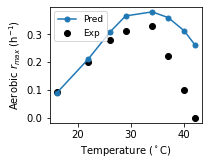

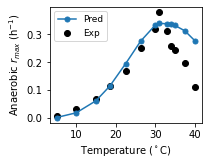

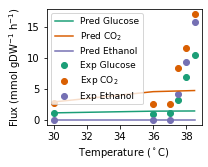

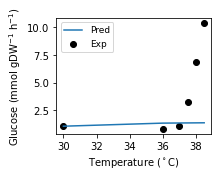

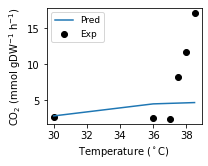

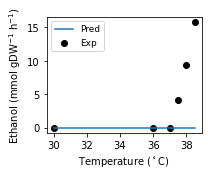

In [12]:
plt.figure(figsize=(3,2.4))
plt.scatter(dfae_batch.index,dfae_batch['r_ae'].values,label='Exp',color='k')
plt.plot(dfae_batch.index,rae['data'],markersize=5,marker='o',label='Pred')
plt.xlabel('Temperature ($^\circ$C)')
#plt.ylabel('Specific growth rate (h$^{-1}$)')
plt.ylabel('Aerobic $r_{max}$ (h$^{-1}$)')

plt.legend(fontsize=9,loc='upper left')
plt.tight_layout()
plt.savefig('../figures/simulated_results_with_start_points_ae_batch.pdf')
plt.show()

plt.figure(figsize=(3,2.4))
plt.scatter(dfan_batch.index,dfan_batch['r_an'].values,label='Exp',color='k')
plt.plot(dfan_batch.index,ran['data'],markersize=5,marker='o',label='Pred')
plt.xlabel('Temperature ($^\circ$C)')
plt.ylabel('Anaerobic $r_{max}$ (h$^{-1}$)')
plt.legend(fontsize=9)
plt.tight_layout()
plt.savefig('../figures/simulated_results_with_start_points_an_batch.pdf')
plt.show()

plt.figure(figsize=(3,2.4))
mets = ['Glucose','CO2','Ethanol']
labels = ['Glucose','CO$_2$','Ethanol']
cs = ['#1b9e77', '#d95f02', '#7570b3']
for i in range(3):
    plt.scatter(dfchemo.index, dfchemo[mets[i]],label='Exp {0}'.format(labels[i]),color=cs[i])
    plt.plot(dfchemo.index, chem['data'][i*6:(i+1)*6],label='Pred {0}'.format(labels[i]),color=cs[i])
plt.xlabel('Temperature ($^\circ$C)')
plt.ylabel('Flux (mmol gDW$^{-1}$ h$^{-1}$)')
plt.legend(fontsize=9)

plt.tight_layout()
plt.savefig('../figures/simulated_results_with_start_points_ae_chemo.pdf')
plt.show()


mets = ['Glucose','CO2','Ethanol']
labels = ['Glucose','CO$_2$','Ethanol']
cs = ['#1b9e77', '#d95f02', '#7570b3']
for i in range(3):
    plt.figure(figsize=(3,2.4))
    plt.scatter(dfchemo.index, dfchemo[mets[i]],label='Exp'.format(labels[i]),color='k')
    plt.plot(dfchemo.index, chem['data'][i*6:(i+1)*6],label='Pred'.format(labels[i]))
    plt.xlabel('Temperature ($^\circ$C)')
    plt.ylabel(labels[i]+' (mmol gDW$^{-1}$ h$^{-1}$)')
    plt.legend(fontsize=9)

    plt.tight_layout()
    plt.savefig('../figures/simulated_results_with_start_points_ae_chemo_{0}.pdf'.format(mets[i]))
    plt.show()


# Permuting parameters

In [13]:
# Proof of concept
%load_ext autoreload
%autoreload 2
rng = np.random.default_rng(492)
from permute_parameters import permute_params
n_enzymes = params.shape[0]
Topt_order = np.random.choice(n_enzymes,size=n_enzymes)
new_df = pd.DataFrame()
new_df["Topt"] = params["Topt"].to_numpy()[Topt_order]
permute_params(params=params,rng=rng)

,Topt,Topt_std,Length,Tm,Tm_std,T90,dCpt,dCpt_std
O13525,308.15,13,869,315.562373,3.40000,NaN,-6300,2000
P00044,312.15,13,392,322.997375,3.40000,NaN,-6300,2000
P00045,311.15,13,552,334.393701,3.40000,NaN,-6300,2000
P00127,312.15,13,376,324.625351,5.91247,NaN,-6300,2000
P00128,309.15,13,688,324.625351,5.91247,327.35,-6300,2000
...,...,...,...,...,...,...,...,...
P81451,307.15,13,600,324.625351,5.91247,335.95,-6300,2000
P00401,307.15,13,269,316.453602,3.40000,NaN,-6300,2000
P00410,314.15,13,335,327.275508,3.40000,327.15,-6300,2000
P00420,318.15,13,477,324.594547,3.40000,325.35,-6300,2000


In [14]:
# Now for the real thing
rng = np.random.default_rng(45834)
n_param_sets = 10
param_sets = [permute_params(params, rng) for _ in range(n_param_sets)]

In [15]:
class SimulationRes:
    def __init__(self, params: pd.DataFrame, aerobic_res: dict, anaerobic_res: dict, chemostat_res: dict) -> None:
        self.params = params
        self.rae: dict[str, np.ndarray] = aerobic_res
        self.ran: dict[str, np.ndarray] = anaerobic_res
        self.chem: dict[str, np.ndarray] = chemostat_res
    

In [16]:
def simulate_effect_of_params(params):
    rae = aerobic(params)
    ran = anaerobic(params)
    chem = chemostat(params)
    return SimulationRes(params, rae, ran, chem)
    

In [17]:
""" from multiprocessing import Pool
n_cores = 10
with Pool(n_cores) as p:
    simulation_res = p.map(simulate_effect_of_params, param_sets)
 """

' from multiprocessing import Pool\nn_cores = 10\nwith Pool(n_cores) as p:\n    simulation_res = p.map(simulate_effect_of_params, param_sets)\n '

In [18]:
""" with open(file="../data/random_permutation_results_with_starts_parms.pkl", mode="wb") as f:
    pickle.dump(obj= simulation_res,file=f) """

' with open(file="../data/random_permutation_results_with_starts_parms.pkl", mode="wb") as f:\n    pickle.dump(obj= simulation_res,file=f) '

In [37]:
with open(file="../data/random_permutation_results_with_starts_parms.pkl", mode="rb") as f:
    simulation_res = pickle.load(file=f)

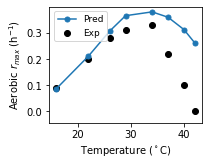

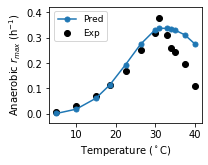

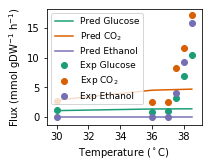

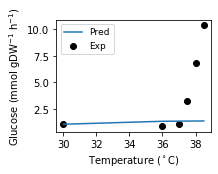

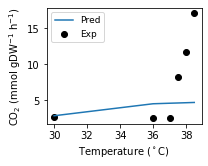

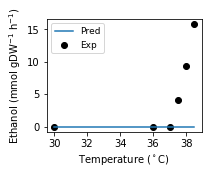

In [38]:
def graph_results(res: SimulationRes):
    plt.figure(figsize=(3,2.4))
    plt.scatter(dfae_batch.index,dfae_batch['r_ae'].values,label='Exp',color='k')
    plt.plot(dfae_batch.index,res.rae['data'],markersize=5,marker='o',label='Pred')
    plt.xlabel('Temperature ($^\circ$C)')
    plt.ylabel('Specific growth rate (h$^{-1}$)')
    plt.ylabel('Aerobic $r_{max}$ (h$^{-1}$)')

    plt.legend(fontsize=9,loc='upper left')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(3,2.4))
    plt.scatter(dfan_batch.index,dfan_batch['r_an'].values,label='Exp',color='k')
    plt.plot(dfan_batch.index,res.ran['data'],markersize=5,marker='o',label='Pred')
    plt.xlabel('Temperature ($^\circ$C)')
    plt.ylabel('Anaerobic $r_{max}$ (h$^{-1}$)')
    plt.legend(fontsize=9)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(3,2.4))
    mets = ['Glucose','CO2','Ethanol']
    labels = ['Glucose','CO$_2$','Ethanol']
    cs = ['#1b9e77', '#d95f02', '#7570b3']
    for i in range(3):
        plt.scatter(dfchemo.index, dfchemo[mets[i]],label='Exp {0}'.format(labels[i]),color=cs[i])
        plt.plot(dfchemo.index, res.chem['data'][i*6:(i+1)*6],label='Pred {0}'.format(labels[i]),color=cs[i])
        plt.xlabel('Temperature ($^\circ$C)')
        plt.ylabel('Flux (mmol gDW$^{-1}$ h$^{-1}$)')
        plt.legend(fontsize=9)

        plt.tight_layout()
        plt.show()


    mets = ['Glucose','CO2','Ethanol']
    labels = ['Glucose','CO$_2$','Ethanol']
    cs = ['#1b9e77', '#d95f02', '#7570b3']
    for i in range(3):
        plt.figure(figsize=(3,2.4))
        plt.scatter(dfchemo.index, dfchemo[mets[i]],label='Exp'.format(labels[i]),color='k')
        plt.plot(dfchemo.index, res.chem['data'][i*6:(i+1)*6],label='Pred'.format(labels[i]))
        plt.xlabel('Temperature ($^\circ$C)')
        plt.ylabel(labels[i]+' (mmol gDW$^{-1}$ h$^{-1}$)')
        plt.legend(fontsize=9)
        plt.tight_layout()
        plt.show()


Random parameter set 0


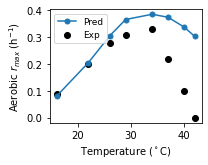

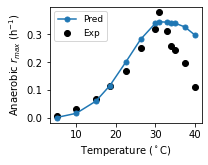

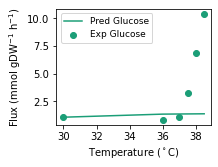

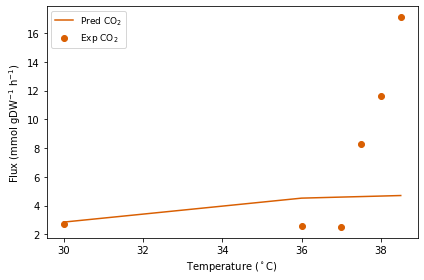

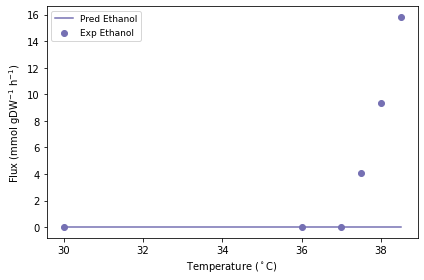

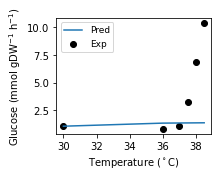

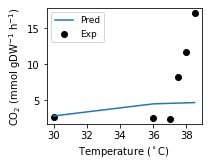

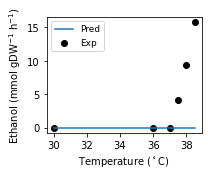

Random parameter set 1


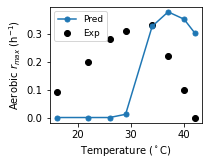

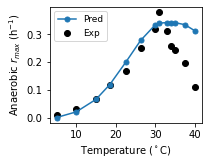

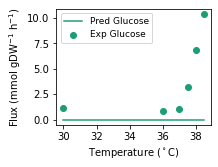

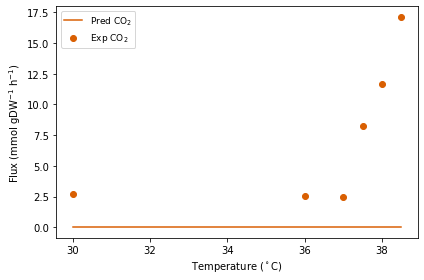

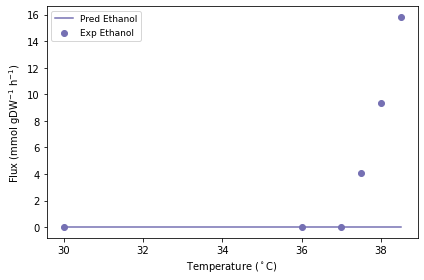

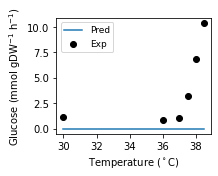

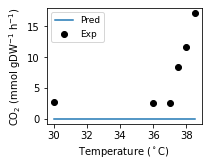

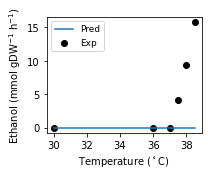

Random parameter set 2


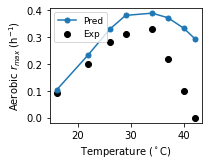

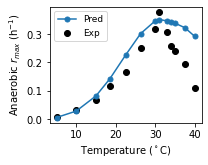

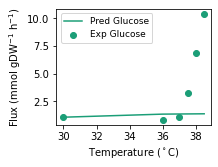

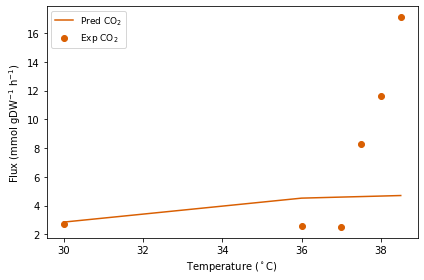

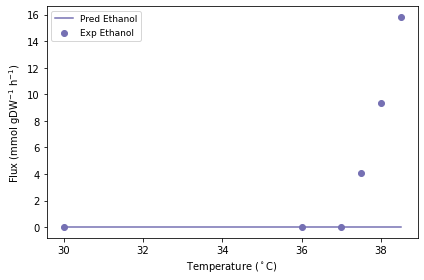

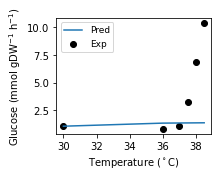

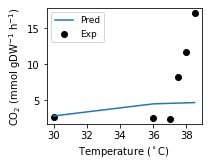

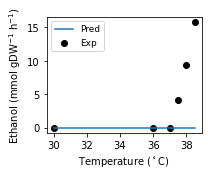

Random parameter set 3


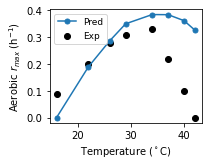

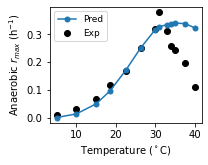

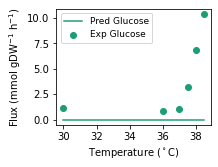

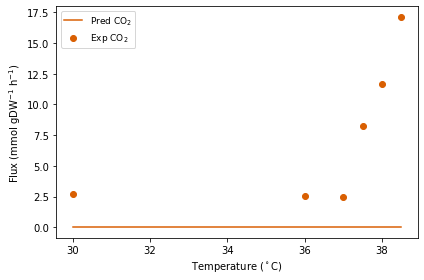

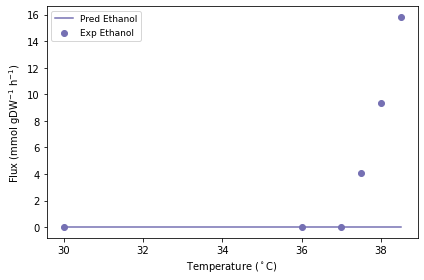

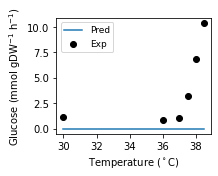

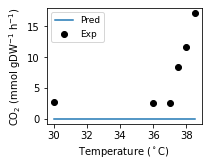

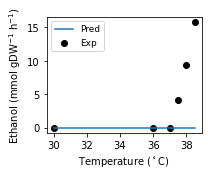

Random parameter set 4


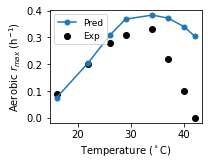

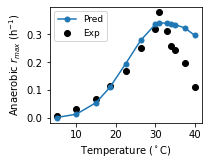

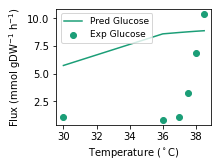

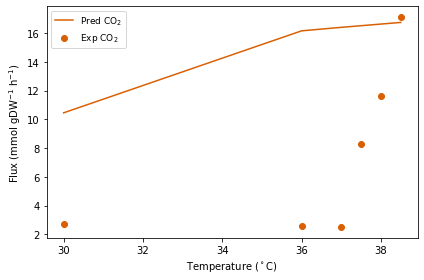

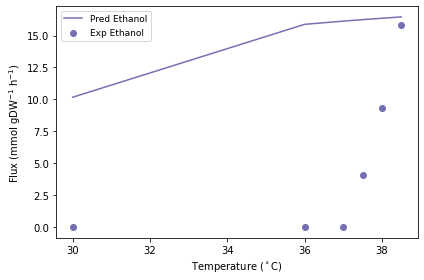

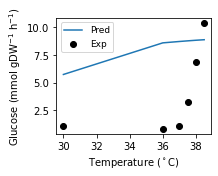

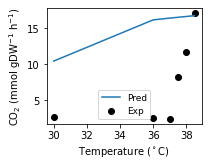

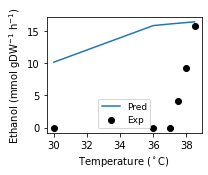

Random parameter set 5


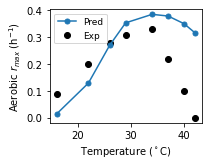

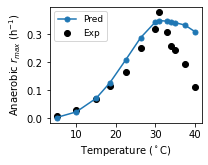

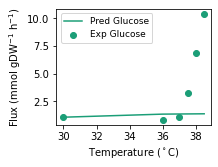

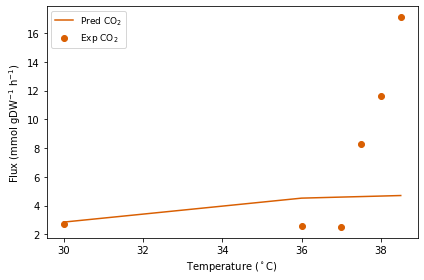

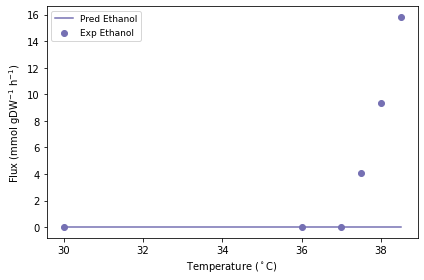

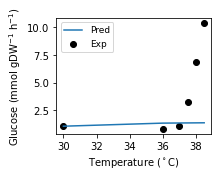

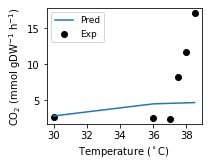

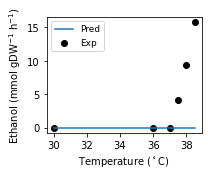

Random parameter set 6


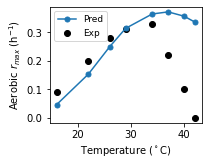

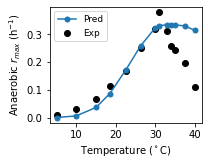

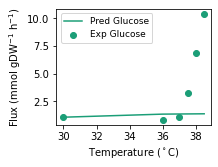

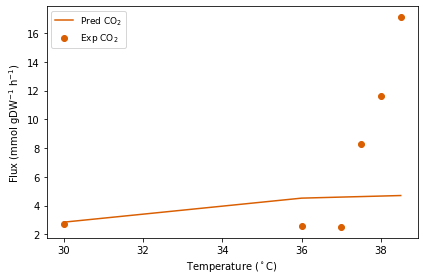

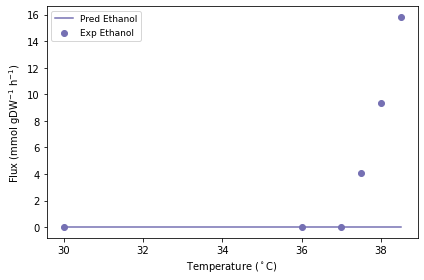

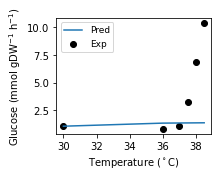

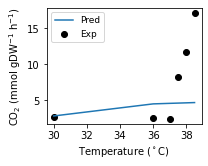

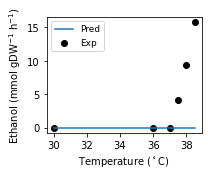

Random parameter set 7


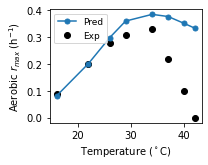

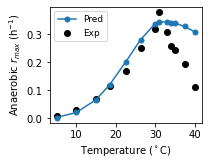

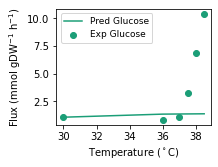

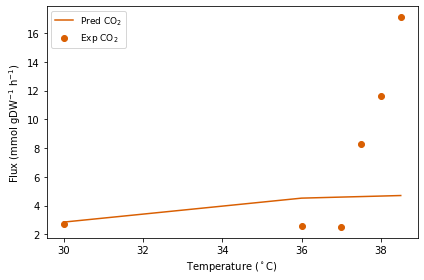

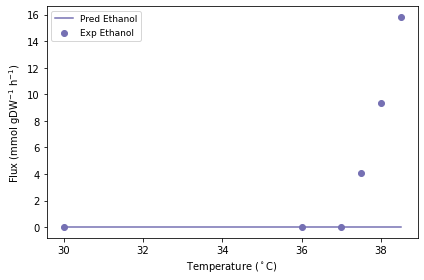

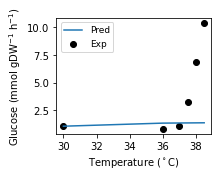

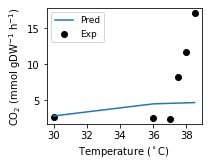

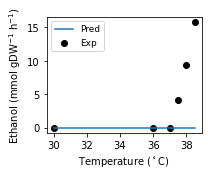

Random parameter set 8


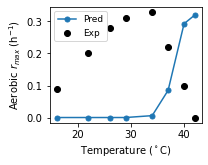

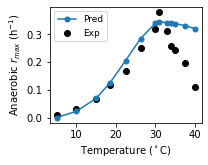

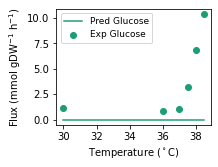

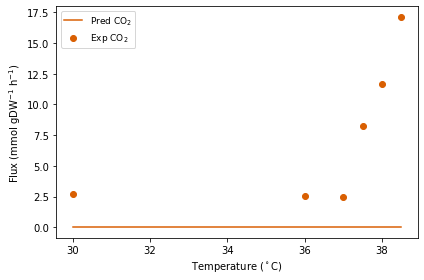

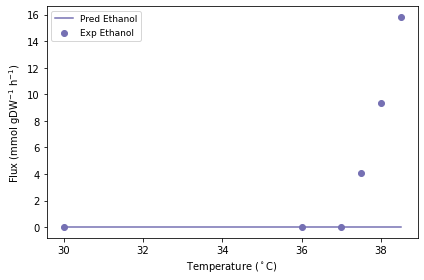

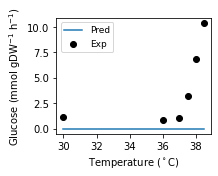

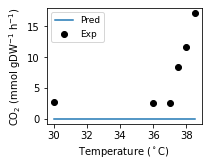

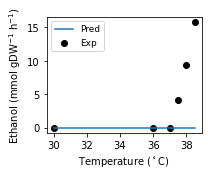

Random parameter set 9


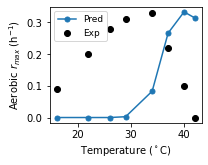

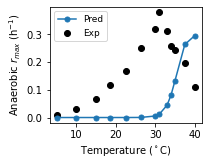

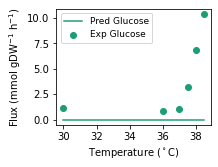

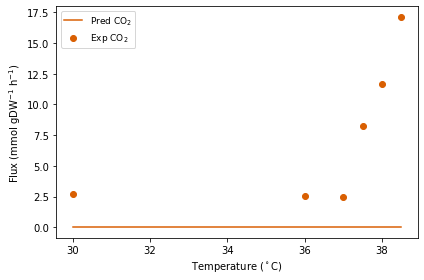

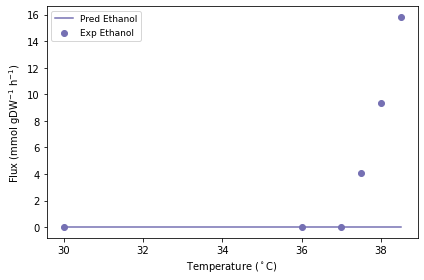

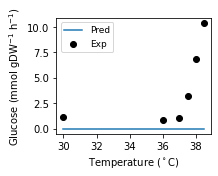

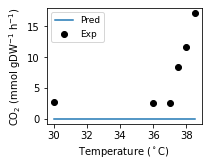

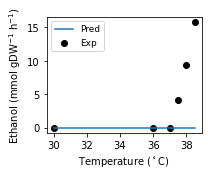

In [39]:
for i, res in enumerate(simulation_res):
    print(f"Random parameter set {i}")
    graph_results(res)

Surprisingly, this seems more or less like the results with the proper starting parameters (at least in some cases). We attribute this somewhat odd observation with the fact that the general shape of the enzyme kinetic curves stay more or less the same, so all enzymes behave more or less the same initially. We next look at the error associated with the simulations.

In [75]:
experimental_data = pd.DataFrame({'experiment' : ["aerobic", "anaerobic", "chemostat"], 
'data' : [x()["data"] for x in [GEMS.aerobic_exp_data, GEMS.anaerobic_exp_data, GEMS.chemostat_exp_data]]})
experimental_data_dict = dict(zip(experimental_data.experiment, experimental_data.data))

In [76]:
experimental_data_dict

{'aerobic': array([0.09, 0.2 , 0.28, 0.31, 0.33, 0.22, 0.1 , 0.  ]),
 'anaerobic': array([0.008, 0.03 , 0.068, 0.115, 0.167, 0.25 , 0.319, 0.379, 0.309,
        0.258, 0.242, 0.195, 0.111]),
 'chemostat': array([ 1.12,  0.87,  1.06,  3.24,  6.85, 10.4 ,  2.74,  2.55,  2.49,
         8.28, 11.65, 17.13,  0.  ,  0.  ,  0.  ,  4.11,  9.34, 15.82])}

In [66]:
comparitive_error_frame = pd.DataFrame([(x, y) for x in (experimental_data.experiment) for y in range(10)],columns= ["experiment", "simulation"]).assign(params = lambda df: [simulation_res[i].params for i in df.simulation],
    results = lambda df: [getattr(simulation_res[row.simulation], {'aerobic' : 'rae', 'anaerobic': 'ran', 'chemostat': 'chem'}[row.experiment])['data'] for row in df.itertuples()])

In [68]:
comparitive_error_frame

,experiment,simulation,params,results
0,aerobic,0,Topt Topt_std Length Tm ...,"[0.07977922398573259, 0.2052530838785778, 0.30..."
1,aerobic,1,Topt Topt_std Length Tm ...,"[0.0, 0.0, 0.0, 0.011506471842787759, 0.326054..."
2,aerobic,2,Topt Topt_std Length Tm ...,"[0.10267722626997036, 0.23471961873943295, 0.3..."
3,aerobic,3,Topt Topt_std Length Tm ...,"[0.0, 0.18958046580508336, 0.2863642629153299,..."
4,aerobic,4,Topt Topt_std Length Tm ...,"[0.07453356331933716, 0.20542095062218843, 0.3..."
5,aerobic,5,Topt Topt_std Length Tm ...,"[0.013337488422170871, 0.12887358764803017, 0...."
6,aerobic,6,Topt Topt_std Length Tm ...,"[0.0450557182090685, 0.1529602397541941, 0.249..."
7,aerobic,7,Topt Topt_std Length Tm ...,"[0.08105036214706177, 0.20151457640335382, 0.2..."
8,aerobic,8,Topt Topt_std Length Tm ...,"[0.0, 0.0, 0.0, 0.0, 0.005843238485490318, 0.0..."
9,aerobic,9,Topt Topt_std Length Tm ...,"[0.0, 0.0, 0.0, 0.0025125985933371815, 0.08316..."


In [56]:
initial_parameter_frame = pd.DataFrame({'experiment' : ["aerobic", "anaerobic", "chemostat"],
 'results': map(lambda x: x['data'],[rae, ran, chem]), 'params': [params]*3, 'origin': 'calculation'})


In [57]:
initial_parameter_frame

,experiment,results,params,origin
0,aerobic,"[0.0873063382103445, 0.21055657710959697, 0.30...",Topt Topt_std Length Tm ...,calculation
1,anaerobic,"[0.0010665102161465574, 0.017988420996753664, ...",Topt Topt_std Length Tm ...,calculation
2,chemostat,"[1.0784201528087605, 1.3562481115501814, 1.368...",Topt Topt_std Length Tm ...,calculation


In [70]:
comparitive_error_frame

,experiment,simulation,params,results
0,aerobic,0,Topt Topt_std Length Tm ...,"[0.07977922398573259, 0.2052530838785778, 0.30..."
1,aerobic,1,Topt Topt_std Length Tm ...,"[0.0, 0.0, 0.0, 0.011506471842787759, 0.326054..."
2,aerobic,2,Topt Topt_std Length Tm ...,"[0.10267722626997036, 0.23471961873943295, 0.3..."
3,aerobic,3,Topt Topt_std Length Tm ...,"[0.0, 0.18958046580508336, 0.2863642629153299,..."
4,aerobic,4,Topt Topt_std Length Tm ...,"[0.07453356331933716, 0.20542095062218843, 0.3..."
5,aerobic,5,Topt Topt_std Length Tm ...,"[0.013337488422170871, 0.12887358764803017, 0...."
6,aerobic,6,Topt Topt_std Length Tm ...,"[0.0450557182090685, 0.1529602397541941, 0.249..."
7,aerobic,7,Topt Topt_std Length Tm ...,"[0.08105036214706177, 0.20151457640335382, 0.2..."
8,aerobic,8,Topt Topt_std Length Tm ...,"[0.0, 0.0, 0.0, 0.0, 0.005843238485490318, 0.0..."
9,aerobic,9,Topt Topt_std Length Tm ...,"[0.0, 0.0, 0.0, 0.0025125985933371815, 0.08316..."


In [95]:
total_error_frame = (comparitive_error_frame.drop('simulation',axis='columns', inplace=False).assign(origin = 'shuffle').
    append(initial_parameter_frame).assign(MSE = lambda df: [MSE(row.results, experimental_data_dict[row.experiment]) for row in df.itertuples()]).
    sort_values(['experiment', 'MSE'], ascending= [True, True])
    )

In [96]:
total_error_frame

,experiment,params,results,origin,MSE
0,aerobic,Topt Topt_std Length Tm ...,"[0.0873063382103445, 0.21055657710959697, 0.30...",calculation,0.017405
2,aerobic,Topt Topt_std Length Tm ...,"[0.10267722626997036, 0.23471961873943295, 0.3...",shuffle,0.022004
0,aerobic,Topt Topt_std Length Tm ...,"[0.07977922398573259, 0.2052530838785778, 0.30...",shuffle,0.022429
4,aerobic,Topt Topt_std Length Tm ...,"[0.07453356331933716, 0.20542095062218843, 0.3...",shuffle,0.022512
5,aerobic,Topt Topt_std Length Tm ...,"[0.013337488422170871, 0.12887358764803017, 0....",shuffle,0.025582
7,aerobic,Topt Topt_std Length Tm ...,"[0.08105036214706177, 0.20151457640335382, 0.2...",shuffle,0.025701
6,aerobic,Topt Topt_std Length Tm ...,"[0.0450557182090685, 0.1529602397541941, 0.249...",shuffle,0.026077
3,aerobic,Topt Topt_std Length Tm ...,"[0.0, 0.18958046580508336, 0.2863642629153299,...",shuffle,0.026924
1,aerobic,Topt Topt_std Length Tm ...,"[0.0, 0.0, 0.0, 0.011506471842787759, 0.326054...",shuffle,0.049392
9,aerobic,Topt Topt_std Length Tm ...,"[0.0, 0.0, 0.0, 0.0025125985933371815, 0.08316...",shuffle,0.054703
